# Image Models

## Objectif

Ce notebook permet de générer les jeux de données contenant les pixels des images, puis d'entrainer des modèles.

## 1. Paramètres des jeux de données

Veuillez renseigner les paramètres ci-dessous pour définir les jeux de données

In [1]:
# Define the dataset size
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

# Define the images characteristics
WIDTH = 100
HEIGHT = 100
KEEP_RATIO = True
GRAYSCALE = True

# Number of threads to use with images conversion
NB_THREADS = 4


## 2. Génération des jeux de données

Veuillez executer la cellule ci-dessous. Attention, l'étape de pré-processing des images peut être longue si vous avez un gros jeu de données. 

In [2]:
import os
import pickle
import src.data.data as data
import importlib
from src.data import transformer
from sklearn.model_selection import train_test_split

importlib.reload(transformer)
importlib.reload(data)

df = data.load_data()
target = df["prdtypecode"]
features = df.drop("prdtypecode", axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    train_size=TRAIN_SIZE,
                                                    test_size=TEST_SIZE)

transformer = transformer.ImagePipeline(width=WIDTH, height=HEIGHT,
                                        keep_ratio=KEEP_RATIO,
                                        grayscale=GRAYSCALE,
                                        nb_threads=NB_THREADS)

img_output_dir = transformer.output_dir.split('/')[1]
pipeline = transformer.pipeline

print("Transformation du jeu de données d'entrainement")
X_train = pipeline.fit_transform(X_train)
print("Transformation du jeu de données de test")
X_test = pipeline.transform(X_test)

files = {
    "data/training/X_train.pkl": X_train,
    "data/training/X_test.pkl": X_test,
    "data/training/y_train.pkl": y_train,
    "data/training/y_test.pkl": y_test
}

print("Enregistrement des données")
if not os.path.exists("data/training"):
    os.makedirs("data/training")

for filename in files.keys():
    with open(filename, 'wb') as fp:
        pickle.dump(files[filename], fp)


Avancement : 100%
Enregistrement des données


Attention, il est maintenant recommandé de redémarrer le kernel Jupyter pour vider la RAM utilisée par la cellule ci-dessus.

Veuillez à exécuter de nouveau la première cellule pour charger les constantes.

## 3. Entrainement du modèle

Instanciez votre modèle dans la cellule ci-dessous, puis executer les cellules à la suite.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

ESTIMATOR_FILE_NAME = "RandomForestClassifier"

params = {
    "n_estimators": [50, 100, 150, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", "None"],
}
ESTIMATOR = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1),
    param_grid=params,
    cv=2,
    n_jobs=-1
)


In [3]:
from sklearn.metrics import accuracy_score
import os
import pickle

X_train = pickle.load(open("data/training/X_train.pkl", "rb"))
y_train = pickle.load(open("data/training/y_train.pkl", "rb"))

X_test = pickle.load(open("data/training/X_test.pkl", "rb"))
y_test = pickle.load(open("data/training/y_test.pkl", "rb"))

ESTIMATOR.fit(X_train, y_train)
y_train_pred = ESTIMATOR.predict(X_train)
print("Score train :", accuracy_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = ESTIMATOR.predict(X_test)
print("Score test  :", accuracy_score(y_true=y_test, y_pred=y_test_pred))

if not os.path.exists("data/models"):
    os.makedirs("data/models")

with open(f"data/models/{ESTIMATOR_FILE_NAME}", 'wb') as fp:
    pickle.dump(ESTIMATOR, fp)


c:\Users\jlagu\miniforge3\envs\rakuten\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jlagu\miniforge3\envs\rakuten\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jlagu\miniforge3\envs\rakuten\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\jlagu\miniforge3\envs\rakuten\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constra

Score train : 0.9951716422304657
Score test  : 0.45325011775788976


In [7]:
print(ESTIMATOR.best_params_)


{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}


In [11]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

          10       0.45      0.44      0.44       630
          40       0.54      0.28      0.37       481
          50       0.57      0.16      0.25       337
          60       0.94      0.21      0.35       161
        1140       0.51      0.22      0.31       563
        1160       0.70      0.70      0.70       826
        1180       0.81      0.10      0.18       165
        1280       0.29      0.13      0.18      1006
        1281       0.24      0.02      0.04       417
        1300       0.41      0.54      0.47      1018
        1301       0.81      0.21      0.34       164
        1302       0.62      0.14      0.22       515
        1320       0.40      0.21      0.27       625
        1560       0.41      0.37      0.39       999
        1920       0.78      0.69      0.73       851
        1940       0.82      0.09      0.16       163
        2060       0.34      0.41      0.37      1009
        2220       1.00    

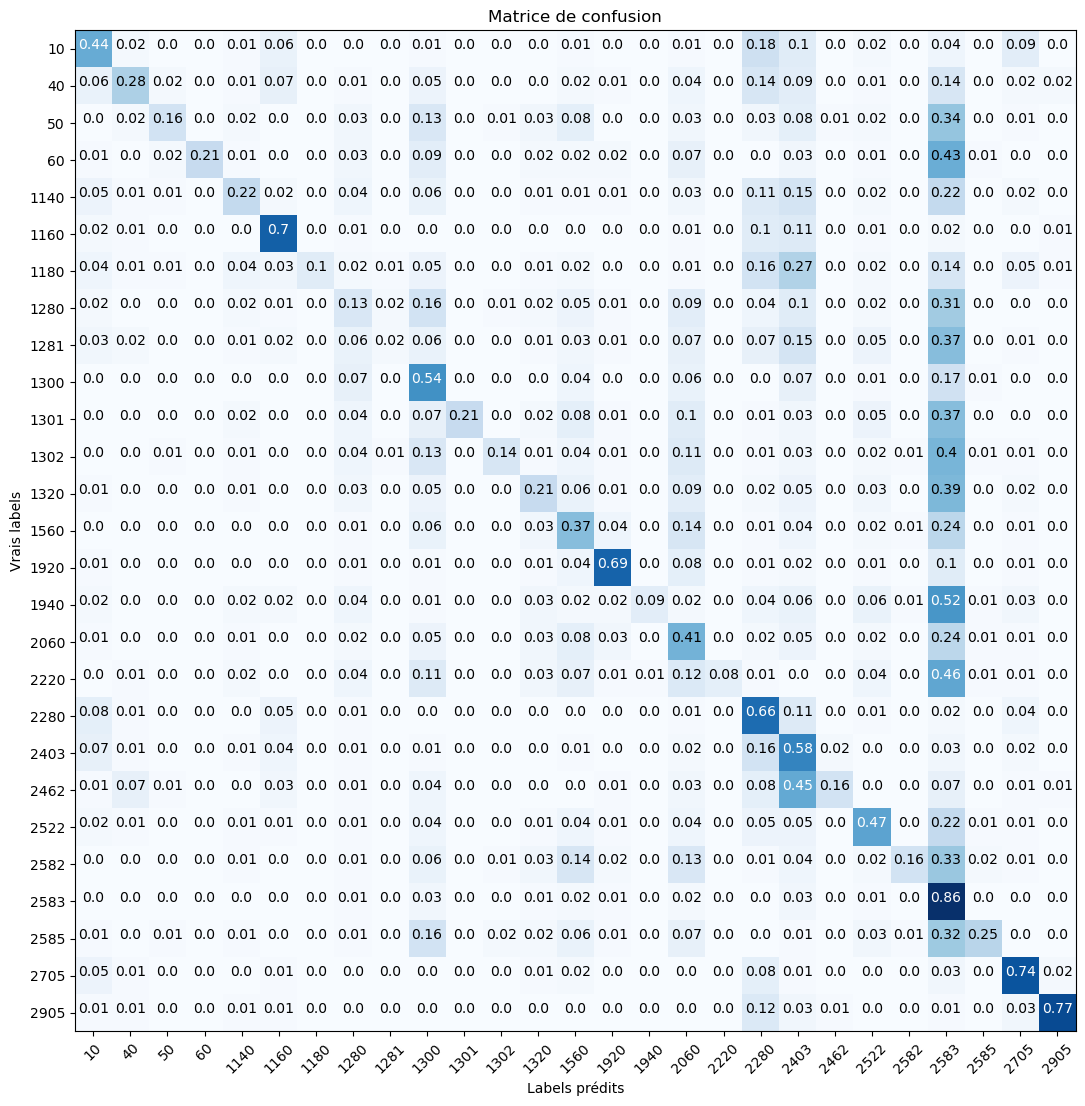

In [45]:
import itertools
from matplotlib import pyplot as plt
import numpy as np


cnf_matrix = np.round(metrics.confusion_matrix(
    y_test, y_test_pred, normalize="true"), 2)

prdtypecodes = np.unique(y_test)
classes = range(0, len(prdtypecodes))

plt.figure(figsize=(13, 13))

plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matrice de confusion")
tick_marks = classes
plt.xticks(tick_marks, prdtypecodes)
plt.yticks(tick_marks, prdtypecodes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.xticks(rotation=45)
plt.show()
